# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**:
* **region_one** - данные геологоразведки первого региона
* **region_two** - данные геологоразведки второго региона
* **region_three** - данные геологоразведки третьего региона
* **id** — уникальный идентификатор скважины
* **f0, f1, f2** — три признака точек (неважно, что они означают, но сами признаки значимы)
* **product** — объём запасов в скважине (тыс. баррелей)

## Загрузка и подготовка данных

In [2]:
!pip install -q phik

In [3]:
# загрузим библиотеки с которыми будем работать
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

from phik.report import correlation_report, plot_correlation_matrix

from matplotlib import rcParams, rcParamsDefault
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [5]:
# загрузим и ознакомимся с датасетами по регионам бурения
region_1 = pd.read_csv('/datasets/geo_data_0.csv') # регион № 1
region_2 = pd.read_csv('/datasets/geo_data_1.csv') # регион № 2
region_3 = pd.read_csv('/datasets/geo_data_2.csv') # регион № 3

In [6]:
display(region_1.head())
region_1.info()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
display(region_2.head())
region_2.info()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
display(region_3.head())
region_3.info()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Построим мультиколинеарность признаков по регионам

CPU times: user 2min 32s, sys: 5.24 s, total: 2min 37s
Wall time: 2min 37s


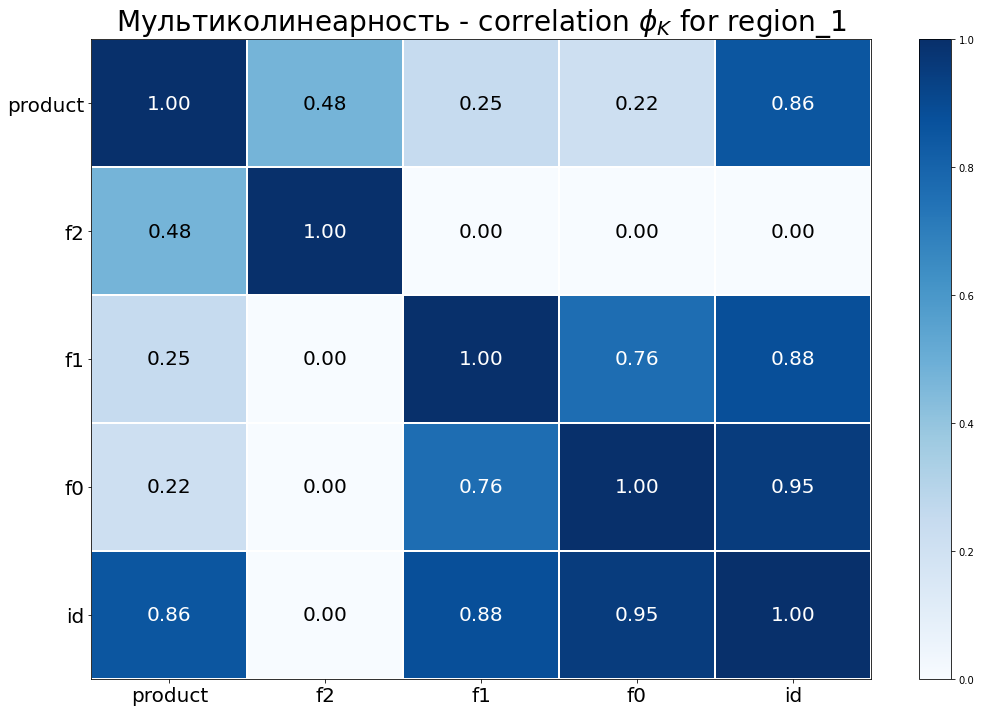

In [9]:
%%time
interval_cols_1 = region_1.select_dtypes('number').columns.tolist()
phik_overview_1 = region_1.phik_matrix(interval_cols=interval_cols_1)
plot_correlation_matrix(phik_overview_1.values,
                        x_labels=phik_overview_1.columns,
                        y_labels=phik_overview_1.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Мультиколинеарность - correlation $\phi_K$ for region_1",
                        fontsize_factor=2,
                        figsize=(15, 10))
plt.xticks(rotation = 0)
plt.tight_layout()

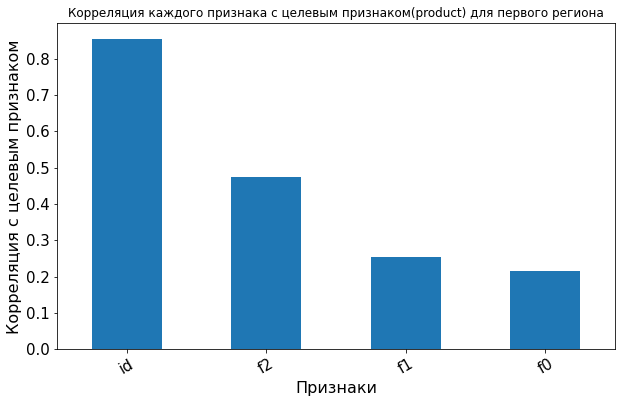

In [10]:
phik_overview_1['product'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(10, 6), fontsize=15)
plt.title('Корреляция каждого признака с целевым признаком(product) для первого региона')
plt.ylabel('Корреляция с целевым признаком', size=16)
plt.xlabel('Признаки', size=16)
plt.xticks(rotation=30)
plt.show()

CPU times: user 2min 56s, sys: 5.51 s, total: 3min 1s
Wall time: 3min 2s


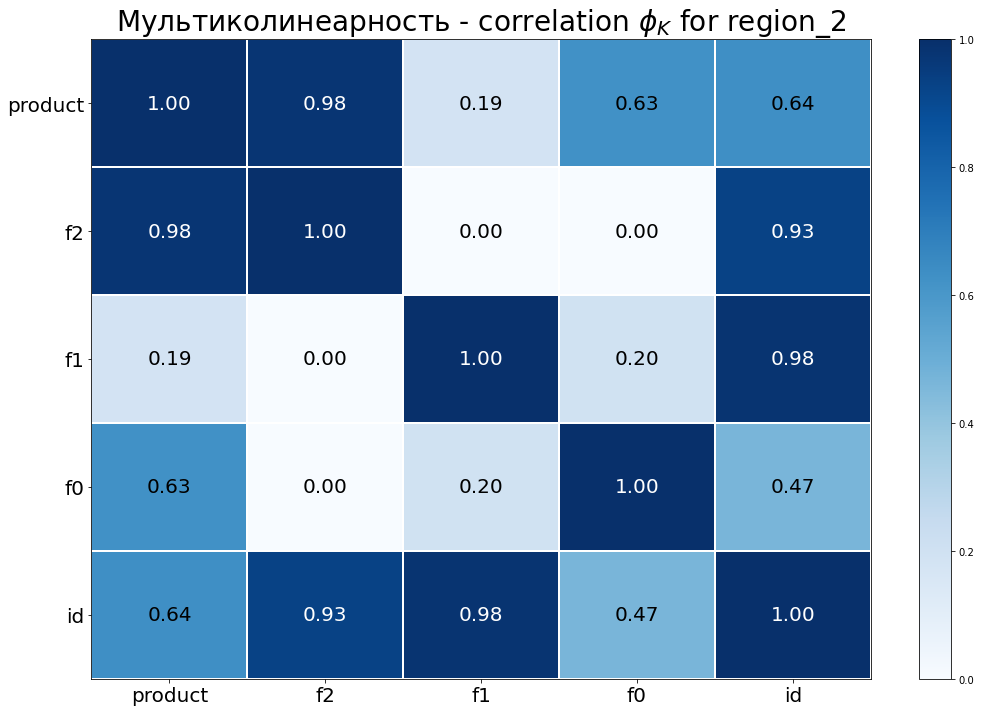

In [11]:
%%time
interval_cols_2 = region_2.select_dtypes('number').columns.tolist()
phik_overview_2 = region_2.phik_matrix(interval_cols=interval_cols_2)
plot_correlation_matrix(phik_overview_2.values,
                        x_labels=phik_overview_2.columns,
                        y_labels=phik_overview_2.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Мультиколинеарность - correlation $\phi_K$ for region_2",
                        fontsize_factor=2,
                        figsize=(15, 10))
plt.xticks(rotation = 0)
plt.tight_layout()

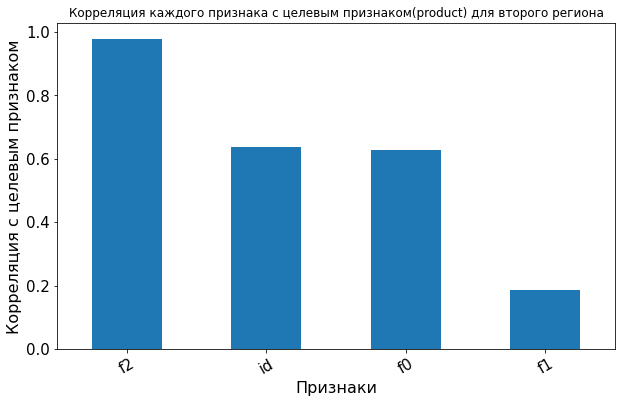

In [12]:
phik_overview_2['product'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(10, 6), fontsize=15)
plt.title('Корреляция каждого признака с целевым признаком(product) для второго региона')
plt.ylabel('Корреляция с целевым признаком', size=16)
plt.xlabel('Признаки', size=16)
plt.xticks(rotation=30)
plt.show()

CPU times: user 2min 39s, sys: 5.22 s, total: 2min 45s
Wall time: 2min 45s


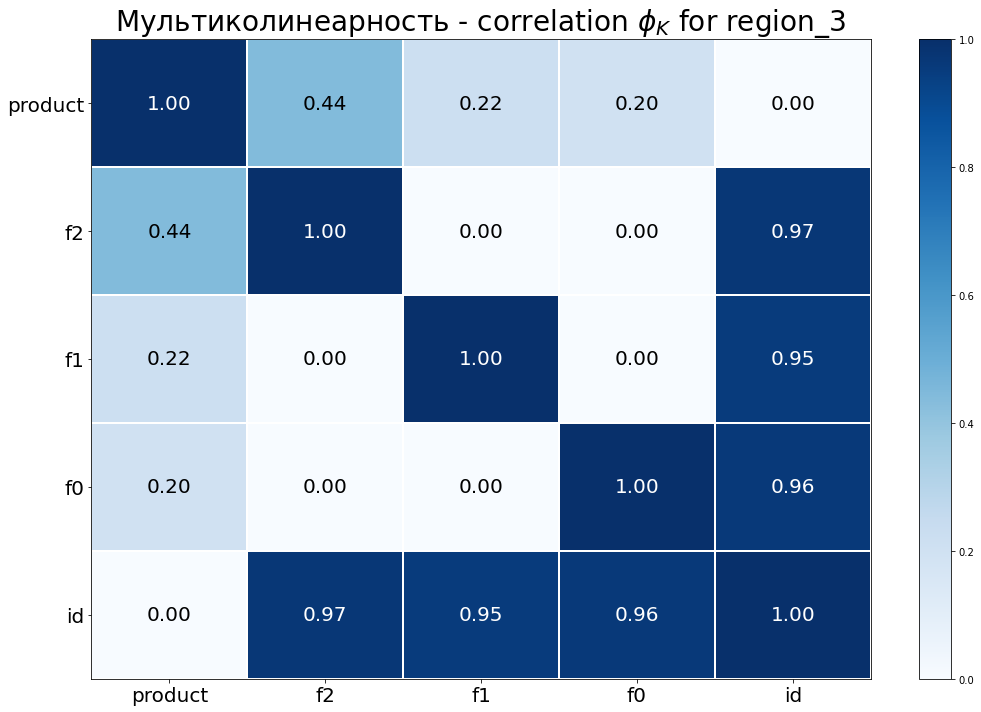

In [13]:
%%time
interval_cols_3 = region_3.select_dtypes('number').columns.tolist()
phik_overview_3 = region_3.phik_matrix(interval_cols=interval_cols_3)
plot_correlation_matrix(phik_overview_3.values,
                        x_labels=phik_overview_3.columns,
                        y_labels=phik_overview_3.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Мультиколинеарность - correlation $\phi_K$ for region_3",
                        fontsize_factor=2,
                        figsize=(15, 10))
plt.xticks(rotation = 0)
plt.tight_layout()

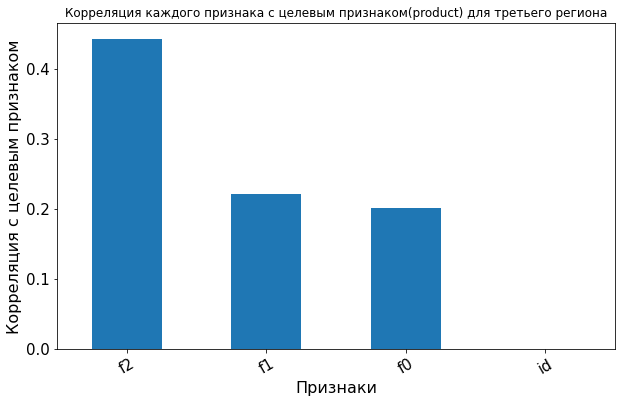

In [14]:
phik_overview_3['product'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(10, 6), fontsize=15)
plt.title('Корреляция каждого признака с целевым признаком(product) для третьего региона')
plt.ylabel('Корреляция с целевым признаком', size=16)
plt.xlabel('Признаки', size=16)
plt.xticks(rotation=30)
plt.show()

In [15]:
# проверим на уникальные значения
display(region_1.nunique())
display(region_2.nunique())
display(region_3.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

В id скорее всего есть дубликаты и что-то странное у второго региона с product, была бы возможность спросил бы у заказчика.

Исключим признак id при обучении, так как он никакой значимости не имеет для прогноза. Суть модели в прогнозе количества сырья на основе характеристик скважины, а сопоставление по id совершенно не влияет. Еще разницы особой с ним или без нету, но все процессы построения и обучения происходят в разы дольше.

In [16]:
region_1 = region_1.drop('id', axis=1)
region_2 = region_2.drop('id', axis=1)
region_3 = region_3.drop('id', axis=1)

Посмотрим основные статистические значения данных по регионам

In [17]:
display(region_1.describe())
display(region_2.describe())
display(region_3.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Посмотрим есть ли в датасетах регионов пропуски или дубликаты:

In [18]:
print(region_1.isna().sum())
region_1.duplicated().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64


0

In [19]:
print(region_2.isna().sum())
region_2.duplicated().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64


0

In [20]:
print(region_3.isna().sum())
region_3.duplicated().sum()

f0         0
f1         0
f2         0
product    0
dtype: int64


0

**Вывод:**

Теперь датасет каждого региона содержит 100000 строк и 4 столбца, они все представлены вещественным типом. В датасете нету пропусков и дубликатов. Также названия столбцов соответствуют змеиному регистру.
* Регион 1 - среднее и медиана почти единтичные, средние квадратичное отклонение = 44, нормальное распределение
* Регион 2 - среднее выше, чем медиана, значит присутствует большой разброс между данными. Также значение запаса меньше, чем в регионах 1 и 3
* Регион 3 - практически аналогично региону 1, но запасов чуть чуть больше.

## Обучение и проверка модели

In [21]:
target_1 = region_1['product']# Целевой признак
features_1 = region_1.drop('product', axis=1)# Признаки

target_2 = region_2['product']# Целевой признак
features_2 = region_2.drop('product', axis=1)# Признаки

target_3 = region_3['product']# Целевой признак
features_3 = region_3.drop('product', axis=1)# Признаки


In [22]:
# разобьем выборки на тренировочную и валидационную
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(features_1,\
        target_1, test_size=0.25, random_state=12345)
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(features_2,\
        target_2, test_size=0.25, random_state=12345)
features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(features_3,\
        target_3, test_size=0.25, random_state=12345)

In [24]:
scaler_1 = StandardScaler()
scaler_1.fit(features_train_1)
features_train_1 = scaler_1.transform(features_train_1)
features_valid_1 = scaler_1.transform(features_valid_1)

In [25]:
scaler_2 = StandardScaler()
scaler_2.fit(features_train_2)
features_train_2 = scaler_2.transform(features_train_2)
features_valid_2 = scaler_2.transform(features_valid_2)

In [26]:
scaler_3 = StandardScaler()
scaler_3.fit(features_train_3)
features_train_3 = scaler_3.transform(features_train_3)
features_valid_3 = scaler_3.transform(features_valid_3)

In [27]:
# проверим как разбились выборки
print(features_train_1.shape, features_valid_1.shape, target_train_1.shape, target_valid_1.shape)
print(features_train_2.shape, features_valid_2.shape, target_train_2.shape, target_valid_2.shape)
print(features_train_3.shape, features_valid_3.shape, target_train_3.shape, target_valid_3.shape)

(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)
(75000, 3) (25000, 3) (75000,) (25000,)


Создадим модели линейной регрессии для 3 регионов

In [42]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
pred_1 = model_1.predict(features_valid_1)
# изменим тип pred_1 на Series с наследованным из валидационных данных индексом
#pred_1 = pd.Series(pred_1, index = target_valid_1.index)
mean_1 = round(pred_1.mean(), 2)
mse_1 = mean_squared_error(target_valid_1, pred_1)
rmse_1 = round(mse_1 ** 0.5, 2)
mae_1 = round(mean_absolute_error(target_valid_1, pred_1), 2)
print(f'Регион №1. Средний запас предсказанного сырья: {mean_1}, RMSE = {rmse_1}, MAE = {mae_1}')

Регион №1. Средний запас предсказанного сырья: 92.59, RMSE = 37.58, MAE = 30.92


In [43]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
pred_2 = model_2.predict(features_valid_2)
# изменим тип pred_2 на Series с наследованным из валидационных данных индексом
#pred_2 = pd.Series(pred_2, index = target_valid_2.index)
mean_2 = round(pred_2.mean(), 2)
mse_2 = mean_squared_error(target_valid_2, pred_2)
rmse_2 = round(mse_2 ** 0.5, 2)
mae_2 = round(mean_absolute_error(target_valid_2, pred_2), 2)
print(f'Регион №2. Средний запас предсказанного сырья: {mean_2}, RMSE = {rmse_2}, MAE = {mae_2}')

Регион №2. Средний запас предсказанного сырья: 68.73, RMSE = 0.89, MAE = 0.72


In [44]:
model_3 = LinearRegression()
model_3.fit(features_train_3, target_train_3)
pred_3 = model_3.predict(features_valid_3)
# изменим тип pred_3 на Series с наследованным из валидационных данных индексом
#pred_3 = pd.Series(pred_3, index = target_valid_3.index)
mean_3 = round(pred_3.mean(), 2)
mse_3 = mean_squared_error(target_valid_3, pred_3)
rmse_3 = round(mse_3 ** 0.5, 2)
mae_3 = round(mean_absolute_error(target_valid_3, pred_3), 2)
print(f'Регион №3. Средний запас предсказанного сырья: {mean_3}, RMSE = {rmse_3}, MAE = {mae_3}')

Регион №3. Средний запас предсказанного сырья: 94.97, RMSE = 40.03, MAE = 32.79


**Вывод:**

In [45]:
results_regions = pd.DataFrame(
    {'1': ['Регион 1', 92.59, 37.58, 30.92],
     '2': ['Регион 2', 68.73, 0.89, 0.72],
     '3': ['Регион 3', 94.97, 40.03, 32.79]   
    }
)
results_regions = results_regions.T
results_regions.columns = ['Регион', 'Средний запас предсказанного сырья на одну скважину(тыс. баррелей)', 'rmse', 'mae']
results_regions

,Регион,Средний запас предсказанного сырья на одну скважину(тыс. баррелей),rmse,mae
1,Регион 1,92.59,37.58,30.92
2,Регион 2,68.73,0.89,0.72
3,Регион 3,94.97,40.03,32.79


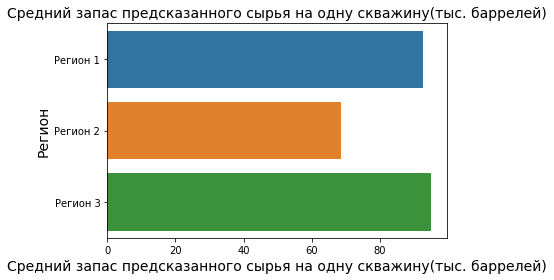

In [46]:
#results_regions['Средний запас предсказанного сырья на одну скважину(тыс. баррелей)'].plot(kind='barh', figsize=(8, 6), fontsize=15)
sns.barplot(x=results_regions['Средний запас предсказанного сырья на одну скважину(тыс. баррелей)'],\
            y=results_regions['Регион'])
#plt.figure(figsize=(8, 6))
plt.title('Средний запас предсказанного сырья на одну скважину(тыс. баррелей)', size=14)
plt.ylabel('Регион', size=14)
plt.xlabel('Средний запас предсказанного сырья на одну скважину(тыс. баррелей)', size=14)
plt.tight_layout()
plt.show()

## Подготовка к расчёту прибыли

In [76]:
# Сохраним в переменные данные значения для расчетов
BEST_MINES = 200 # Количество лучших шахт для расчета прибыли
BUDGET = 10_000_000_000 # Бюджет на разработку скважин в регионе
ONE_BARREL_PRICE = 450  # Доход с одного барреля сырья(руб.)
PRICE = 450_000 # Доход с каждой единицы продукта(т.к. объём указан в тысячах баррелей)
ITERATIONS = 1000
POINTS = 500

In [48]:
# Рассчитаем объём сырья для безубыточной разработки одной скважины
barrel_budget_zero = round(BUDGET / PRICE, 2)
print(f'Для безубыточной работы необходимо вообщем добыть {barrel_budget_zero} единиц продукта')
average_barrel_mine = round(barrel_budget_zero / BEST_MINES, 2)
print(f'Для безубыточной работы 200 скважин в среднем на одну скважину необходимо добыть {average_barrel_mine} единиц продукта')

Для безубыточной работы необходимо вообщем добыть 22222.22 единиц продукта
Для безубыточной работы 200 скважин в среднем на одну скважину необходимо добыть 111.11 единиц продукта


**Вывод:**

In [49]:
difference_1 = round(average_barrel_mine - mean_1, 2)
print(f'Средний предсказанный запас сырья в регионе 1 меньше необходимого минимума единиц продукта достаточного \
для безубыточной разработки на {difference_1} единиц продукта')

difference_2 = round(average_barrel_mine - mean_2, 2)
print(f'Средний предсказанный запас сырья в регионе 2 меньше необходимого минимума единиц продукта достаточного \
для безубыточной разработки на {difference_2} единиц продукта')
difference_3 = round(average_barrel_mine - mean_3, 2)

print(f'Средний предсказанный запас сырья в регионе 3 меньше необходимого минимума единиц продукта достаточного \
для безубыточной разработки на {difference_3} единиц продукта')

Средний предсказанный запас сырья в регионе 1 меньше необходимого минимума единиц продукта достаточного для безубыточной разработки на 18.52 единиц продукта
Средний предсказанный запас сырья в регионе 2 меньше необходимого минимума единиц продукта достаточного для безубыточной разработки на 42.38 единиц продукта
Средний предсказанный запас сырья в регионе 3 меньше необходимого минимума единиц продукта достаточного для безубыточной разработки на 16.14 единиц продукта


## Расчёт прибыли и рисков 

In [63]:
def profit(target, predictions, count, price, budget):
    predictions_sorted = predictions.sort_values(ascending = False)
    selected = target[predictions_sorted.index][:count]
    total_income = selected.sum() * price
    gain = total_income - budget
    return gain

In [81]:
pred_1 = pd.Series(pred_1, index=target_valid_1.index)
region1_predicted_income = profit(
    target_valid_1,
    pred_1,
    BEST_MINES,
    PRICE,
    BUDGET)
print(f'Прибыль региона №1 по 200 лучшим скважинам(млрд.рублей): {round(region1_predicted_income, 2)}')

Прибыль региона №1 по 200 лучшим скважинам(млрд.рублей): 3320826043.14


In [82]:
pred_2 = pd.Series(pred_2, index=target_valid_2.index)
region2_predicted_income = profit(
    target_valid_2,
    pred_2,
    BEST_MINES,
    PRICE,
    BUDGET)
print(f'Прибыль региона №2 по 200 лучшим скважинам(млрд.рублей): {round(region2_predicted_income, 2)}')

Прибыль региона №2 по 200 лучшим скважинам(млрд.рублей): 2415086696.68


In [83]:
pred_3 = pd.Series(pred_3, index=target_valid_3.index)
region3_predicted_income = profit(
    target_valid_3,
    pred_3,
    BEST_MINES,
    PRICE,
    BUDGET)
print(f'Прибыль региона №3 по 200 лучшим скважинам(млрд.рублей): {round(region3_predicted_income, 2)}')

Прибыль региона №3 по 200 лучшим скважинам(млрд.рублей): 2710349963.6


Максимальная прибыль у региона №1

In [68]:
def bootstrap(target, probabilities, iterations, points):
    state = np.random.RandomState(12345)
    values = []
    for i in range(iterations):
        target_subsample = target.sample(n=points, replace=True, random_state=state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(profit(target_subsample, probs_subsample, BEST_MINES, PRICE, BUDGET))
    values = pd.Series(values)
    mean = values.mean()
    risk = (values < 0).mean()
    confidence_interval = st.t.interval(alpha = 0.95, df = len(values)-1, loc=values.mean(), scale=values.sem())
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    quantile_interval = (lower, upper)
    return mean, confidence_interval, quantile_interval, risk*100

In [85]:
region1_mean, region1_interval, region1_quantile, region1_risk = bootstrap(target_valid_1,
                                                                   pred_1, ITERATIONS, POINTS)
print(f'В регионе №1 средняя выручка = {round(region1_mean, 2)}')
print(f'В регионе №1 95% доверительный интервал для среднего по стьюденту = {region1_interval}')
print(f'В регионе №1 95% доверительный интервал для среднего по квантилям = {region1_quantile}')
print(f'В регионе №1 риск убытков: {region1_risk}%')

В регионе №1 средняя выручка = 425938526.91
В регионе №1 95% доверительный интервал для среднего по стьюденту = (408732207.06869864, 443144846.7524862)
В регионе №1 95% доверительный интервал для среднего по квантилям = (-102090094.83793654, 947976353.3583689)
В регионе №1 риск убытков: 6.0%


In [86]:
region2_mean, region2_interval, region2_quantile, region2_risk = bootstrap(target_valid_2,
                                                                   pred_2, ITERATIONS, POINTS)
print(f'В регионе №2 средняя выручка = {round(region2_mean, 2)}')
print(f'В регионе №2 95% доверительный интервал для среднего по стьюденту = {region2_interval}')
print(f'В регионе №2 95% доверительный интервал для среднего по квантилям = {region2_quantile}')
print(f'В регионе №2 риск убытков: {region2_risk}%')

В регионе №2 средняя выручка = 515222773.44
В регионе №2 95% доверительный интервал для среднего по стьюденту = (501621476.17632174, 528824070.710258)
В регионе №2 95% доверительный интервал для среднего по квантилям = (68873225.37050176, 931547591.2570494)
В регионе №2 риск убытков: 1.0%


In [87]:
region3_mean, region3_interval, region3_quantile, region3_risk = bootstrap(target_valid_3,
                                                                   pred_3, ITERATIONS, POINTS)
print(f'В регионе №3 средняя выручка = {round(region3_mean, 2)}')
print(f'В регионе №3 95% доверительный интервал для среднего по стьюденту = {region3_interval}')
print(f'В регионе №3 95% доверительный интервал для среднего по квантилям = {region3_quantile}')
print(f'В регионе №3 риск убытков: {region3_risk}%')

В регионе №3 средняя выручка = 435008362.78
В регионе №3 95% доверительный интервал для среднего по стьюденту = (417453552.0413578, 452563173.5241534)
В регионе №3 95% доверительный интервал для среднего по квантилям = (-128880547.32978901, 969706954.1802661)
В регионе №3 риск убытков: 6.4%


**Вывод:**

In [88]:
itog_results_regions = pd.DataFrame(
    {'1': ['Регион №1', 425.938, '-102.090 --- 947.976', 6.0],
     '2': ['Регион №2', 515.222, '68.873 --- 931.547', 1.0],
     '3': ['Регион №3', 435.008, '-128.880 --- 969.706', 6.4]   
    }
)
itog_results_regions = itog_results_regions.T
itog_results_regions.columns = ['Регион', 'Средняя выручка(млн.)',
                           'Доверительный интервал(по квантилям млн.)', 'Процент риска убытков']
itog_results_regions

,Регион,Средняя выручка(млн.),Доверительный интервал(по квантилям млн.),Процент риска убытков
1,Регион №1,425.938,-102.090 --- 947.976,6.0
2,Регион №2,515.222,68.873 --- 931.547,1.0
3,Регион №3,435.008,-128.880 --- 969.706,6.4


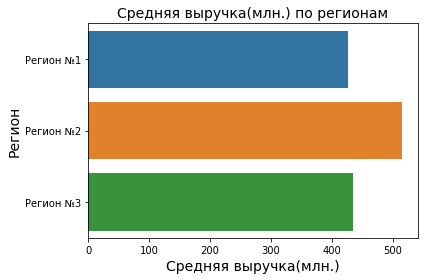

In [89]:
sns.barplot(x=itog_results_regions['Средняя выручка(млн.)'],\
            y=itog_results_regions['Регион'])
plt.title('Средняя выручка(млн.) по регионам', size=14)
plt.ylabel('Регион', size=14)
plt.xlabel('Средняя выручка(млн.)', size=14)
plt.tight_layout()
plt.show()

Исходя из всего выше проделонного исследования, можно сделать вывод по прогнозам сделанным с помощью техники Bootstrap, что самым наиболее прибыльным будет регион №2, на втором месте регион №3, а на последнем месте регион №1. Также нужно отметить, что у второго региона самый лучший показатель доверительного интервала и также низкий процент риска убытков, ещё по условиям задачи нам нужно отобрать самый прибыльный регион и тот у которого риск убытков меньше 2,5%, а у первого и третьего региона процент риска убытков больше необходимого. **Поэтому я предлогаю регион №2 для разработки скважин.**